![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=1+-+BigQuery+Time+Series+Forecasting+Data+Review+and+Preparation.ipynb)

# Time Series Forecasting - Data Review in BigQuery

This series will explore forecasting with Vertex AI and BigQuery and additional frameworks.  Forecasting consist of following a measurement over time and exploring trends, the impact of seasonality (years, months, days, etc), holidays, and special events with the hope of using these insights to forecast into the near future.  Before we look into methods of forecasting, this notebook will first look at a data source with a time element.  

This series will use Citibike rentals in New York city.  The bike stations near central park will be selected and the daily number bike trips that orignate from these stations will be followed over time.  This will illustrate some common forecasting issues due to new stations being introduced over time and some stations only have the most recent few months, or just weeks of data.  The data are found in the BigQuery Public datasets at: `bigquery-public-data.new_york.citibike_trips`.

In this notebook we look at the data available and visualize the trend over time.

**Prerequisites:**
-  None

**Resources:**
- Blog: [How to do time series forecasting in BigQuery](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)
- Using BigQuery From Python, Notebooks in This Repository:
    - [Tips/BigQuery - Python Client](../Tips/BigQuery%20-%20Python%20Client.ipynb)
    - [01 - Data Sources/01 - BigQuery - Table Data Sources](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)
    - [03 - BigQuery ML (BQML)/03 - Introduction to BigQuery ML (BQML)](../03%20-%20BigQuery%20ML%20(BQML)/03%20-%20Introduction%20to%20BigQuery%20ML%20(BQML).ipynb)   

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore1_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore1_console.png" width="45%">
</p>

---
## Setup

### Package Installs (if needed)

This notebook uses [plotly](https://plotly.com/python/getting-started/) for interactive vizualizations. 

In [1]:
try:
    import plotly
except ImportError:
    print('You need to pip install plotly')
    !pip install plotly -q

### Environment

inputs:

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [3]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-data'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'
viz_limit = 12

packages:

In [4]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import plotly.express as px
import plotly.graph_objects as go

clients:

In [5]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Data Setup

### Create BigQuery Dataset
Create a BigQuery Dataset within this project if missing:
- [Reference](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.dataset.Dataset.html#google.cloud.bigquery.dataset.Dataset)

In [6]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us' #REGION
ds.labels = {'notebook': f"{EXPERIMENT}"}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [7]:
ds.dataset_id

'applied_forecasting'

In [8]:
ds.full_dataset_id

'statmike-mlops-349915:applied_forecasting'

List BigQuery datasets in the project:

In [9]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
crossvalidation
explained_columns
forecasting_8_tournament
fraud
github_api
model_deployment_monitoring_5876762107113897984


### Review Source Data
Stored in BigQuery Public Datasets

Quick Preview:

In [10]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE1}`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,107,2014-06-06 13:02:01+00:00,2014-06-06 13:03:48+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,16692,Subscriber,1977,male
1,1105,2013-08-24 17:03:52+00:00,2013-08-24 17:22:17+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,15352,Customer,<NA>,unknown
2,990,2014-04-25 11:52:28+00:00,2014-04-25 12:08:58+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,20194,Subscriber,1973,male
3,138,2015-08-20 16:58:57+00:00,2015-08-20 17:01:16+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,21002,Subscriber,1977,male
4,78,2014-09-13 13:18:36+00:00,2014-09-13 13:19:54+00:00,520,W 52 St & 5 Ave,40.759923,-73.976485,520,W 52 St & 5 Ave,40.759923,-73.976485,19259,Customer,<NA>,unknown


In [11]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE2}`
    LIMIT 5
"""
bq.query(query).to_dataframe()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,495,W 47 St & 10 Ave,6824.07,40.762699,-73.993012,71,"KEY, CREDITCARD",0,False,0,0,0,0,True,True,True,False,1970-01-02 00:00:00+00:00
1,3171,Amsterdam Ave & W 82 St,7360.10,40.785247,-73.976673,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
2,3603,31 Ave & 30 St,6857.09,40.764700,-73.924031,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
3,3733,Avenue C & E 18 St,5769.04,40.730563,-73.973984,71,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00
4,3792,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,70,"KEY, CREDITCARD",0,False,0,0,0,0,False,False,False,False,1970-01-02 00:00:00+00:00


Review miss-matches in stations names between the two source tables:

In [12]:
query = """
    WITH
        STATIONS AS (
            SELECT distinct name as stations
            FROM `bigquery-public-data.new_york.citibike_stations`
            WHERE name LIKE '%Central Park%'
        ),
        TRIPS AS (
            SELECT distinct start_station_name as trips
            FROM `bigquery-public-data.new_york.citibike_trips`
            WHERE start_station_name LIKE '%Central Park%'   
        )
    SELECT *
    FROM STATIONS a
    FULL JOIN TRIPS b
    on a.stations = b.trips
"""
bq.query(query).to_dataframe()

,stations,trips
0,Central Park W & W 97 St,None
1,None,Central Park W & W 96 St
2,7 Ave & Central Park South,None
3,Central Park W & W 103 St,None
4,None,Central Park West & W 100 St
5,W 106 St & Central Park West,W 106 St & Central Park West
6,Central Park West & W 76 St,Central Park West & W 76 St
7,Central Park S & 6 Ave,Central Park S & 6 Ave
8,Central Park North & Adam Clayton Powell Blvd,Central Park North & Adam Clayton Powell Blvd
9,Central Park West & W 85 St,Central Park West & W 85 St


### Create a Source Table or View
It is common to need to combine multiple sources together to bring together all the data needed for forecasting.  Here, multiple source tables are referenced to create a combined forecasting source table.

The goal is one row per time point for each time series.  The means aggregating the transaction to a demand signal for each time series and each time point (day, month, quarter, ...).

If all of the data needed for forecasting is already prepared then a statement like this might not be needed.  Adapting this code to your situation it could be a simple as:

```SQL
CREATE OR REPLACE VIEW `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
SELECT *
FROM {BQ_SOURCE}
```

In [13]:
# CUSTOMIZE
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source` AS
WITH
    STATION AS (
        SELECT
           start_station_name,
           EXTRACT(DATE FROM starttime) AS starttime,
           COUNT(*) AS num_trips,
           AVG(tripduration) as avg_tripduration,
           COUNTIF(usertype='Subscriber')/COUNT(*) as pct_subscriber,
           SAFE_DIVIDE(COUNTIF(gender='male'), COUNTIF(gender!='male')) as ratio_gender
        FROM `{BQ_SOURCE1}`
        WHERE start_station_name LIKE '%Central Park%'
        GROUP BY start_station_name, starttime
    ),
    STATION_INFO AS (
        SELECT
            name,
            max(capacity) as capacity
        FROM `{BQ_SOURCE2}`
        WHERE name LIKE '%Central Park%'
        GROUP BY name
    )
SELECT * EXCEPT(name)
FROM STATION A
LEFT OUTER JOIN STATION_INFO B
ON A.start_station_name = B.name
ORDER BY start_station_name, starttime
"""
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

2.477

### Prepare Data for Forecasting

Parameters and common queries used for [cte](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#simple_cte).

If this notebook is being used as a starting point for a different data source then the cell below is a great place to customize the variables, time/date, filtering, and calculation of demand.

In [14]:
# CUSTOMIZE THIS CELL
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

Quick Summary of Series with totals and date ranges for each series:

In [15]:
query = f"""
    SELECT {SERIES_COLUMN}, sum({TARGET_COLUMN}) as {TARGET_COLUMN}, min({TIME_COLUMN}) as FromDate, max({TIME_COLUMN}) as ToDate
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
overview = bq.query(query).to_dataframe()
overview.head(viz_limit)

,start_station_name,num_trips,FromDate,ToDate
0,Central Park North & Adam Clayton Powell Blvd,4808,2016-09-01,2016-09-30
1,Central Park S & 6 Ave,172220,2013-07-01,2016-09-30
2,Central Park W & W 96 St,5905,2016-08-04,2016-09-30
3,Central Park West & W 100 St,2245,2016-08-08,2016-09-30
4,Central Park West & W 102 St,2851,2016-08-08,2016-09-30
5,Central Park West & W 68 St,35192,2015-09-01,2016-09-30
6,Central Park West & W 72 St,44574,2015-09-01,2016-09-30
7,Central Park West & W 76 St,27919,2015-09-09,2016-09-30
8,Central Park West & W 85 St,43895,2015-10-07,2016-09-23
9,Grand Army Plaza & Central Park S,163815,2013-07-01,2016-09-30


Visualize each series date/time range:

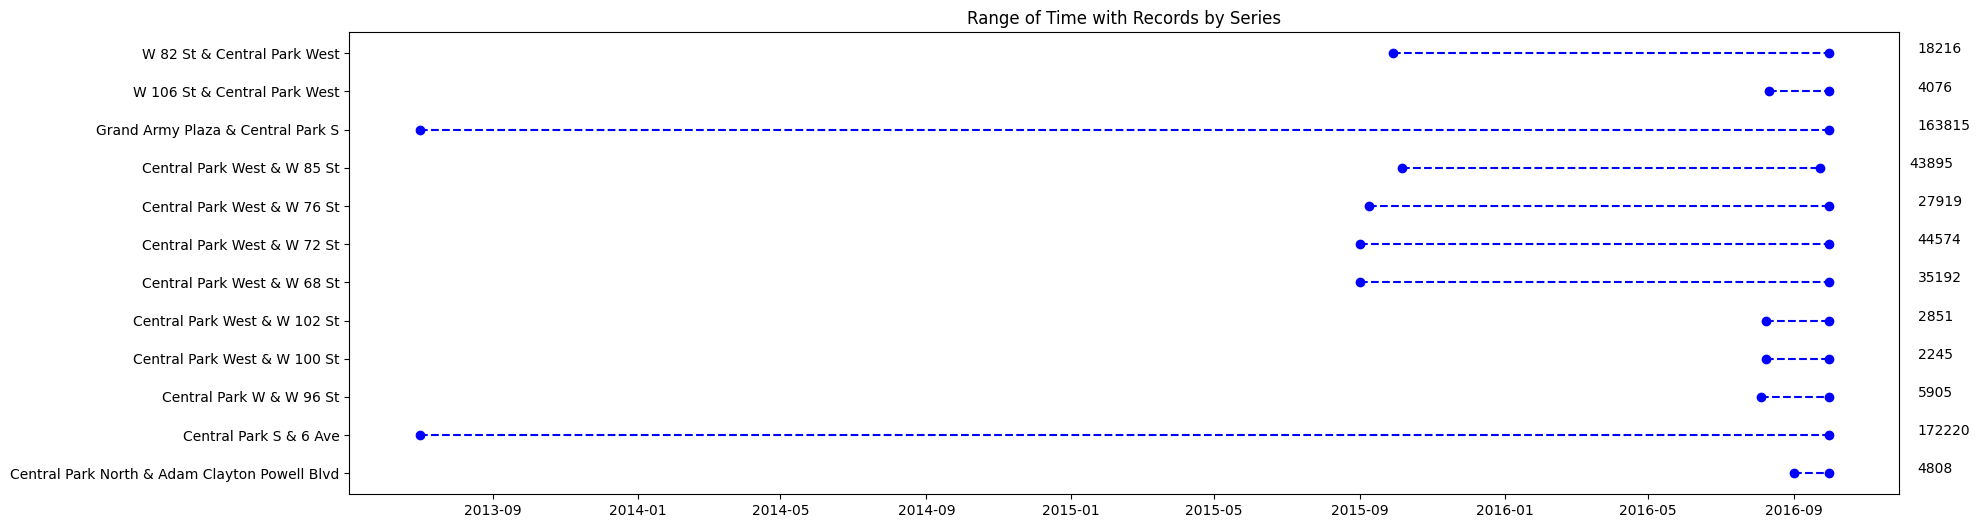

In [16]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records by Series')
plt.show()

In [17]:
query = f"""
    SELECT DISTINCT {SERIES_COLUMN}, {TIME_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
dates = bq.query(query).to_dataframe()

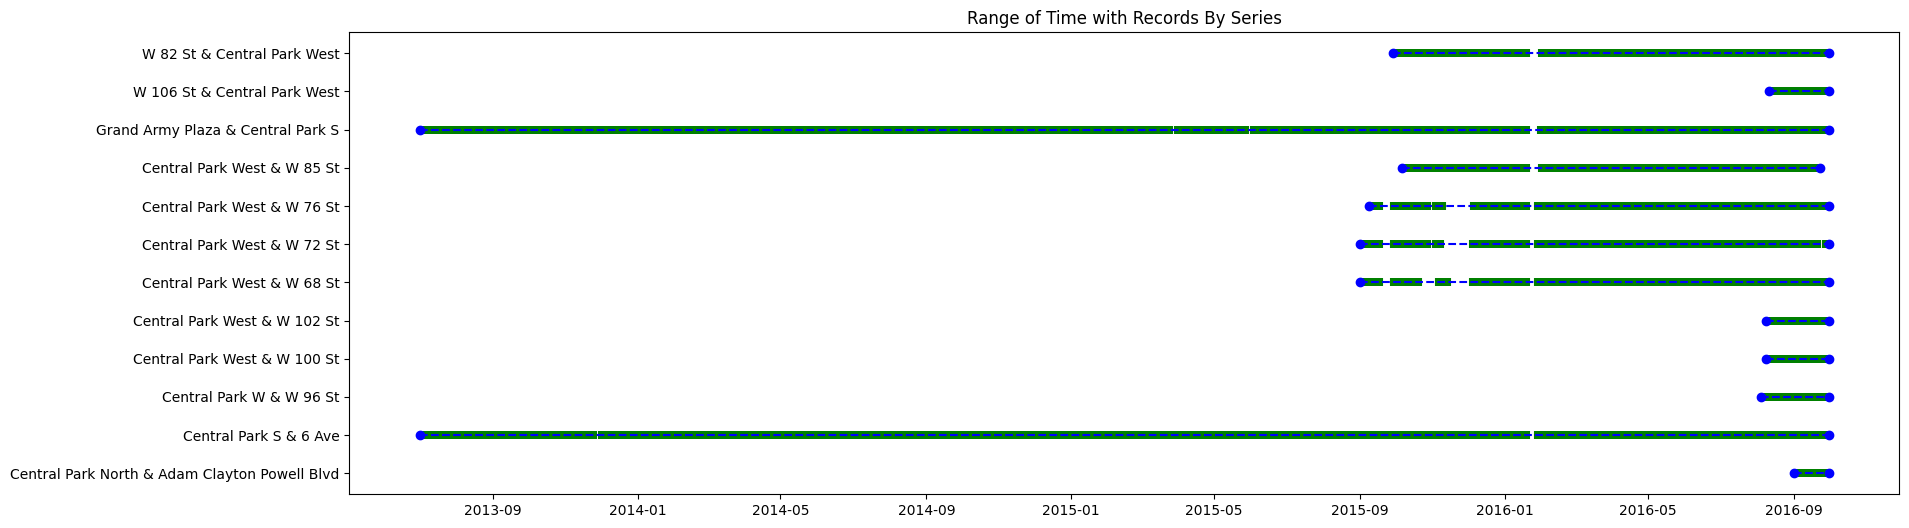

In [18]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    # subset dates to current series and plot dates with records on timelines for each series:
    tempdates = dates[(dates[SERIES_COLUMN] == overview[SERIES_COLUMN][i])]
    plt.scatter(tempdates[TIME_COLUMN], tempdates[SERIES_COLUMN], c='g', marker='|')
    plt.title('Range of Time with Records By Series')
plt.show()

### Propose Train/Validation/Test Splits by Date Range

Get key dates from the series data while setting the forcast horizon:

In [19]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
forecast_val_length = 14

In [20]:
query = f"""
    SELECT 
        MIN({TIME_COLUMN}) as start_date,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length+forecast_val_length}-1 DAY) as val_start,
        DATE_SUB(MAX({TIME_COLUMN}), INTERVAL {forecast_test_length}-1 DAY) as test_start,
        MAX({TIME_COLUMN}) as end_date
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`  
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Visualize each series date/time range with proposed data segments from key dates:

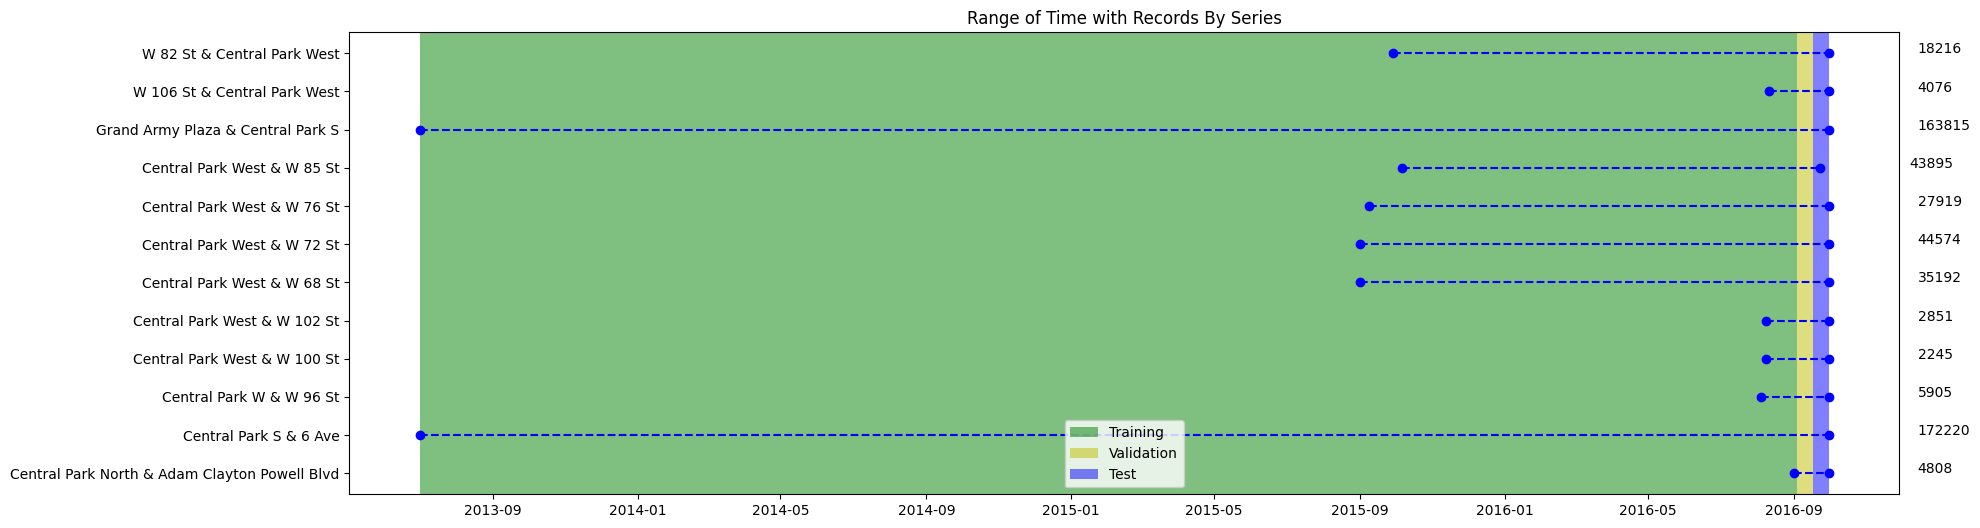

In [21]:
plt.figure(figsize=(20,6))
for i in range(viz_limit):
    x = [overview['FromDate'][i], overview['ToDate'][i]]
    y = [overview[SERIES_COLUMN][i], overview[SERIES_COLUMN][i]]
    plt.plot(x, y, 'bo', linestyle="--")
    plt.text(x[1]+timedelta(75), y[0], str(overview[TARGET_COLUMN][i]))
    plt.title('Range of Time with Records By Series')
plt.axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.5, label = 'Training')
plt.axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.5, label = 'Validation')
plt.axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.5, label = 'Test')
plt.legend(loc = 'lower center')
plt.show()

## Create BigQuery Table for Forecasting
Put it all together!

In [22]:
query = f"""
    CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped` AS
    SELECT *,
       CASE
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length} {forecast_granularity}) THEN "TEST"
           WHEN {TIME_COLUMN} > DATE_SUB((SELECT MAX({TIME_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`), INTERVAL {forecast_test_length}+{forecast_val_length} {forecast_granularity}) THEN "VALIDATE"
           ELSE "TRAIN"
       END AS splits
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_source`
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

1.901

## Review Forecasting Data

In [23]:
query = f"""
    SELECT 
        {SERIES_COLUMN},
        COUNTIF(splits='TRAIN') as TRAIN,
        COUNTIF(splits='VALIDATE') as VALIDATE,
        COUNTIF(splits='TEST') as TEST,
        sum({TARGET_COLUMN}) as {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}
"""
splitCounts = bq.query(query).to_dataframe()
splitCounts.head(viz_limit)

,start_station_name,TRAIN,VALIDATE,TEST,num_trips
0,Central Park North & Adam Clayton Powell Blvd,2,14,14,4808
1,Central Park S & 6 Ave,1149,14,14,172220
2,Central Park W & W 96 St,30,14,14,5905
3,Central Park West & W 100 St,26,14,14,2245
4,Central Park West & W 102 St,26,14,14,2851
5,Central Park West & W 68 St,331,14,14,35192
6,Central Park West & W 72 St,334,14,13,44574
7,Central Park West & W 76 St,327,14,14,27919
8,Central Park West & W 85 St,324,14,7,43895
9,Grand Army Plaza & Central Park S,1152,14,13,163815


Totals by data split:

In [24]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum()

TRAIN       4055
VALIDATE     168
TEST         159
dtype: int64

Overall total:

In [25]:
splitCounts[['TRAIN','VALIDATE','TEST']].sum().sum()

4382

Visualize days of data available for forecasting at each series:

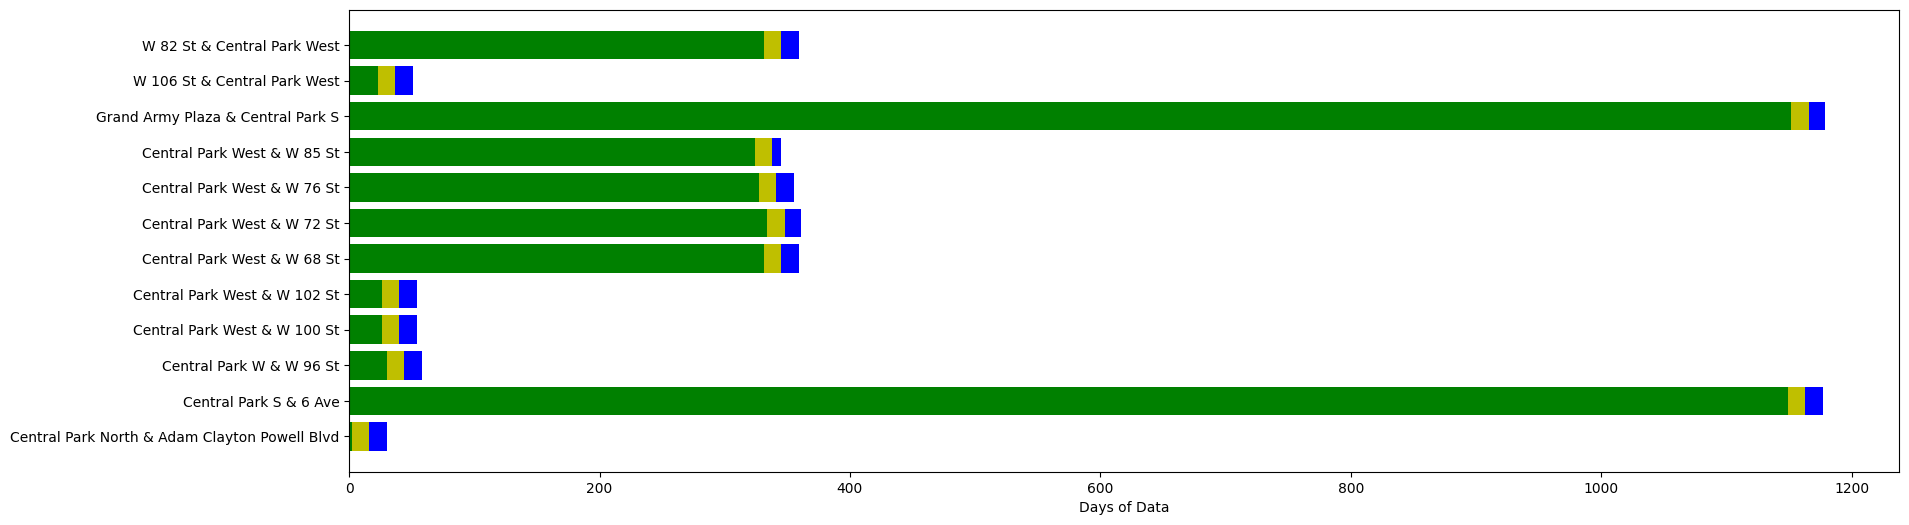

In [26]:
tempsplitCounts = splitCounts.iloc[0:viz_limit]
plt.figure(figsize=(20,6))
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TRAIN'], color = 'g')
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['VALIDATE'], color = 'y', left = tempsplitCounts['TRAIN'])
plt.barh(tempsplitCounts[SERIES_COLUMN], tempsplitCounts['TEST'], color = 'b', left = tempsplitCounts['TRAIN'] + tempsplitCounts['VALIDATE'])
plt.xlabel('Days of Data')
plt.show()

## Validation Check: Extract dates for splits from source

In [27]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


## Validation Check: Duplicate Dates in Series?
Are there any series with data for duplicate dates?

In [28]:
query = f"""
    WITH
        DAYS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, count(*) as records
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        )
    SELECT *
    FROM DAYS
    WHERE records > 1
"""
bq.query(query).to_dataframe()

,start_station_name,starttime,records


## Time Series Review

In [29]:
query = f"""
    SELECT 
        {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series

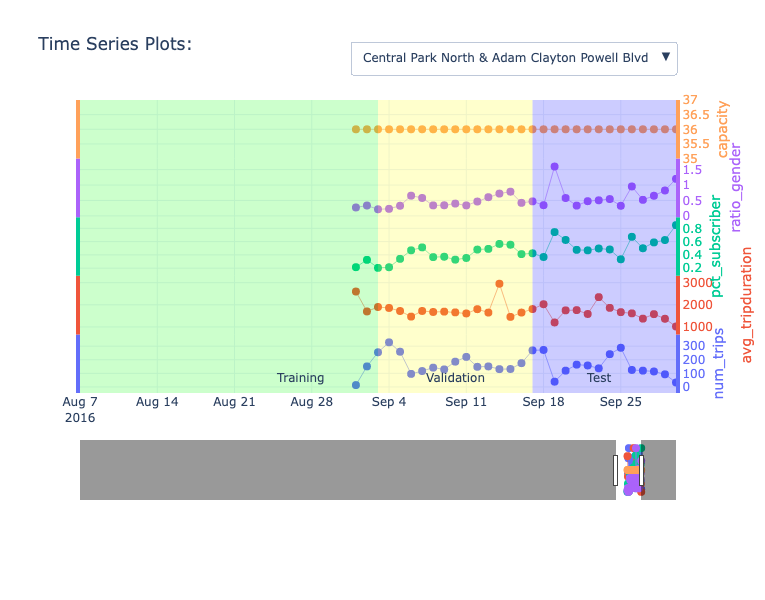

In [54]:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

fig = go.Figure()

# get a list of colors:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# use button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make first series visible as default
            )
        )
    
    # which button to show:
    which_buttons = [False] * len(series) * len(variables)
    which_buttons[b * len(variables):(b+1)*len(variables)] = [True] * len(variables)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)

# annotate split regions
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

fig.show()

---
## Remove Resources
see notebook "99 - Cleanup"